# CMD models for JWST

The goal with this notebook is to create a model for the Color Magnitude Diagram of JWST Nircam filters F200W, F300M, F335M, F360M. For the testing part, I am using the MakeCMD function from the XRBID package and I will try to update that function to incorporate JWST.

In [1]:
import re
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as img
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from scipy.interpolate import interp1d
from astropy.io.votable import parse
from numpy import nanmedian, nanstd, nanmean, median, std, mean, log10
import pandas as pd
import os
from XRBID.DataFrameMod import Find, BuildFrame
from XRBID.Sources import LoadSources

cd = os.chdir
pwd = os.getcwd
pd.options.mode.chained_assignment = None

cd('/Users/undergradstudent/Research/XRB-Analysis/jwst-models')
wfc3_masses = [pd.read_csv("isoWFC3_1Msun.frame"), pd.read_csv("isoWFC3_3Msun.frame"), pd.read_csv("isoWFC3_5Msun.frame"),
	       pd.read_csv("isoWFC3_8Msun.frame"), pd.read_csv("isoWFC3_20Msun.frame")]

acs_masses = [pd.read_csv("isoACS_WFC_1Msun.frame"), pd.read_csv("isoACS_WFC_3Msun.frame"), pd.read_csv("isoACS_WFC_5Msun.frame"),
	      pd.read_csv("isoACS_WFC_8Msun.frame"), pd.read_csv("isoACS_WFC_20Msun.frame")]

isoacs = pd.read_csv("isoACS_all.frame")
isowfc3 = pd.read_csv("isoWFC3_all.frame")

In [2]:
headers = "Zini     MH   logAge Mini        int_IMF         Mass   logL    logTe  logg  label   McoreTP C_O  period0  period1  period2  period3  period4  pmode  Mloss  tau1m   X   Y   Xc  Xn  Xo  Cexcess  Z 	 mbolmag  F070W  F090W F115W  F150W  F200W  F277W  F356W F444W  F150W2  F322W2  F140M F162M  F182M  F210M F250M  F300M  F335M  F360M  F410M  F430M F460M  F480M"
names=[i for i in headers.split(" ") if i != "" and i != "\t"]
isoTemp = pd.read_csv("solarmass.txt", delim_whitespace=True, comment="#", names=names)
isoTemp["ID"] = [i for i in range(len(isoTemp))]
solarmass1 = Find(isoTemp, 'Mass == 1')
solarmass2 = Find(isoTemp, 'Mass == 2')
solarmass3 = Find(isoTemp, 'Mass == 3')
solarmass5_temp = Find(isoTemp, 'Mass >= 5')
solarmass5 = Find(solarmass5_temp, 'Mass <= 5.07')
solarmass8_temp = Find(isoTemp, 'Mass >= 7.999')
solarmass8 = Find(solarmass8_temp, 'Mass <= 8.099')
solarmass20_temp = Find(isoTemp, 'Mass >= 19.5')
solarmass20 = Find(solarmass20_temp, 'Mass <= 20.3')

# Testing with color magnitude diagrams

## Functions

In [6]:
def MakeCMD(sources=False, xcolor=None, ycolor=None, xmodel=None, ymodel=None, figsize=(6,4), xlim=None, ylim=None, color="black", size=10, marker=None, label=None, save=False, savefile=None, title=None, subimg=None, annotation=None, annotation_size=None, imshow=True, fontsize=15, shift_labels=[[0,0],[0,0],[0,0],[0,0],[0,0]], set_labels=None, instrument="ACS", color_correction=[0,0], labelpoints=False, file_dir=False): 

	"""Makes a CMD from a given set of points, either from a list or an input dataframe.

	PARAMETERS: 
	sources 	[pd.dataframe, list]: 	Input may either be a pandas dataframe containing the appropriate magnitudes required for the CMD, 
				       		or a list of coordinates in the format [[xs],[ys]]. 
	xcolor 		[str or list]: 		The name of the color or magnitude to plot in the x-axis, as it is labeled in the dataframe. 
						This will be the default x-axis label. If a list is given, it is assumed to contain the 
						column names of the input dataframe to be subtracted (e.g. F555W - F814W)
	ycolor 		[str or list]: 		The name of the color or magnitude to plot in the y-axis, as it is labeled in the dataframe. 
						This will be the default y-axis label. If a list is given, it is assumed to contain the column 
						names of the input dataframe to be subtracted (e.g. F555W - F814W)
	xmodel 		[str or list]: 		The magnitude(s) of the filter(s) to be used from the stellar models for the x-axis. 
						If given as a list, it is assumed the color is xmodel[0] - xmodel[1] 
	ymodel 		[str or list]: 		The magnitude(s) of the filter(s) to be used from the stellar models for the y-axis. 
						If given as a list, it is assumed the color is ymodel[0] - ymodel[1] 
	figsize 	[tuple] (6,4): 		The desired dimensions of the figure. 
	xlim 		[tuple] (None):		The limits on the x-axis. If none are given, the limits are assumed to be the (xmin - 1, xmax + 1) 
	ylim 		[tuple] (None):		The limits on the y-axis. If none are given, the limits are assumed to be (ymax + 1, ymin - 1)
	color 		[str] ("black"): 	Marker color
	size 		[int] (10): 		Marker size
	marker 		[str] (None):		The style of the marker. Defaults to a filled point. If "o" is given, 
						the marker is set to be an open circle. 
	label 		[str] (None):		The legend label to assign to the input points from sources. 
	save 		[bool] (False): 	Sets whether to automatically same the CMD image. 
	savefile 	[str] (None): 		The name to assigned the saved CMD image. 
	title 		[str] (None): 		Title of the figure.
	subimg 		[str] (None): 		Filename of an image to include in the corner of the CMD. 
						This is to allow a subplot of the XRB plotted to be shown within the CMD. 
	annotation 	[str] (None): 		Additional annotation to add to the bottom corner of the CMD (usually XRB ID)
	annotation_size [int] (None): 		Annotation fontsize 
	imshow 		[bool] (True): 		Shows the plot.
	fontsize 	[int] (20): 		The fontsize of text other than the annoations
	shift_labels 	[list]: 		List of x and y coordinate distances by which to shift each of the model mass labels.
						Defaults to [[0,0],[0,0],[0,0],[0,0],[0,0]] (no shifts)
	set_labels 	[list] (None):		Sets the position of labels. If none is given, positions are automatically calculated.
	instrument 	[str] ("ACS"): 		Name of the instrument used, to determine which models to call. 
	color_correction [list] ([0,0]):	Corrections on the x and y position of the sources. Defaults to no correction. 
	labelpoints 	[list] (False): 	Labels to add to each point. If none are given, defaults to False and no labels added. 
	file_dir 	[str]: 			The directory within which the models may be found. By default, the 
						code attempts to find this automatically, but if it fails, it will 
						prompt the user to input the directory manually. 

	RETURNS: 
	f, ax: 		Arguments defining the figure, which can be used to add more points to the CMD after the initial plotting.
 
	"""

	# Setting the style of my plots
	#fontparams = {'font.family':'stix'}
	#labelparams = {'family':'stix', 'size':fontsize}
	
	curr_dir = pwd()

	# If no file directory is given, assume the files we need are in the same directory
	# where the module is saved
	#if not file_dir: 
	#	file_dir = os.path.dirname(os.path.abspath(__file__))

	#try: cd(file_dir)
	#except: print("Directory containg CMD models not found.\nPlease check and input the correct directory manually with file_dir.")

	# Reading in the appropriate models based on the instrument given.
	#if instrument.upper() =="WFC3":
	#	mass1 = pd.read_csv("isoWFC3_1Msun.frame")
	#	mass3 = pd.read_csv("isoWFC3_3Msun.frame")
	#	mass5 = pd.read_csv("isoWFC3_5Msun.frame")
	#	mass8 = pd.read_csv("isoWFC3_8Msun.frame")
	#	mass20 = pd.read_csv("isoWFC3_20Msun.frame")
	#elif instrument.upper() =="ACS": 
	#	mass1 = pd.read_csv("isoACS_WFC_1Msun.frame")
	#	mass3 = pd.read_csv("isoACS_WFC_3Msun.frame")
	#	mass5 = pd.read_csv("isoACS_WFC_5Msun.frame")
	#	mass8 = pd.read_csv("isoACS_WFC_8Msun.frame")
	#	mass20 = pd.read_csv("isoACS_WFC_20Msun.frame")

	if instrument.upper() =="WFC3": masses = wfc3_masses # list of DataFrames of each mass model
	elif instrument.upper() == 'ACS': masses = acs_masses
	else: masses = [solarmass1, solarmass3, solarmass5, solarmass8, solarmass20]

	mass_labels = [r"1 M$_\odot$", r"3 M$_\odot$", r"5 M$_\odot$", r"8 M$_\odot$", r"20 M$_\odot$"]

	#cd(curr_dir) 

	if savefile: save = True

	# Setting the x- and y-axes labels.
	# if xcolor and/or ycolor is a list, will need to set color[0] - color[1] as the color of the appropriate axis
	if not xcolor: xcolor=xmodel
	if not ycolor: ycolor=ymodel

	if isinstance(xcolor, list): xlabel = " - ".join(xcolor)
	else: xlabel = xcolor
	if isinstance(ycolor, list): ylabel = " - ".join(ycolor)
	else: ylabel = ycolor

	### Pulling the x and y values of the sources ###
	# if input source is a pandas dataframe, read in the appropriate colors and magnitudes (and add correction, if needed)
	if isinstance(sources, pd.DataFrame):
		if isinstance(xcolor, list): xsources = sources[xcolor[0]].values - sources[xcolor[1]].values + color_correction[0]
		else: xsources = sources[xcolor].values + color_correction[0]
		if isinstance(ycolor, list): ysources = sources[ycolor[0]].values - sources[ycolor[1]].values + color_correction[1]
		else: ysources = sources[ycolor].values + color_correction[1]
		
	elif sources: # If sources is a list or coordinates, pull the x and y values as given (with additional color correction)
		xsources = (np.array(sources[0]) + color_correction[0]).tolist()
		ysources = (np.array(sources[1]) + color_correction[1]).tolist()	
	### Will only need to call xsources or ysources from now on ###

	
	### PLOTTING MODEL MASS TRACKS ###

	f, ax = plt.subplots(figsize=figsize)

	# Setting the tick parameters
	ax.tick_params(direction="in", labelsize=15, bottom=True, \
		       top=True, left=True, right=True, length=7, width=2)
	ax.grid(alpha=0.8, linestyle="--")

	# If no xmodel or ymodel are given, default to that of the sources. 
	# This point will fail if the filters of the sources are not given a name corresponding to the filters in the model DataFrame!
	if not xmodel: xmodel=xcolor
	if not ymodel: ymodel=ycolor

	# Pulling the correct colors/magnitudes from the models and plotting
	# and setting the default mass track label position and plot limits
	xlims = []
	ylims = []
	for m, mass in enumerate(masses): # for each of the mass models, pull the color/mag given by xmodel and ymodel
		if isinstance(xmodel, list): 
			xtemp = mass[xmodel[0]].values - mass[xmodel[1]].values
			xtemp_label = max(xtemp) + 0.1 + shift_labels[m][0] # default mass label position, unless set_labels is given
			xtemp_left = max(xtemp)	# Keeping track of the leftmost x coordinate		
			if not xlim: xlims.append([min(xtemp)-1, max(xtemp)+1])
			invert_xlim = False
		else: # if x-axis is a magnitude..
			xtemp = mass[xmodel].values
			xtemp_label = min(xtemp) - 0.1 + shift_labels[m][0]
			xtemp_left = min(xtemp)
			if not xlim: xlims.append([max(xtemp)+1, min(xtemp)-1])
			invert_xlim = True
		if isinstance(ymodel, list): 
			ytemp = mass[ymodel[0]].values - mass[ymodel[1]].values
			if not ylim: ylims.append([min(ytemp)-1, max(ytemp)+1])
			invert_ylim = False
		else: # of y-axis is a magnitude...
			ytemp = mass[ymodel].values
			if not ylim: ylims.append([max(ytemp)+1, min(ytemp)-1])
			invert_ylim = True

		# Finding the best y-coordinate for the model label based on the leftmost
		ytemp_label = ytemp[xtemp.tolist().index(xtemp_left)] + invert_ylim*0.5 + shift_labels[m][1]

		# If set_labels is given, use this as the coordinate of the label
		# (overrides the label positions set above)
		if set_labels: 
			xtemp_label = set_labels[m][0]
			ytemp_label = set_labels[m][1]

		# Plotting mass track and mass label
		plt.plot(xtemp, ytemp, color="black", lw=1)
		ax.annotate(mass_labels[m], xy=(xtemp_label, ytemp_label), size=15)

	xlims = np.array(xlims)
	ylims = np.array(ylims) 

	# PLOTTING SOURCE POINTS
	if isinstance(sources, pd.DataFrame) or isinstance(sources, list): 
		if marker == "o": 	# 'o' used for open circle 
			ax.scatter(xsources, ysources, facecolor="none", edgecolor=color, s=size, label=label)
		elif marker == None: 	# default is a closed circle 
			ax.scatter(xsources, ysources, color=color, s=size, label=label)
		else: 
			ax.scatter(xsources, ysources, color=color, s=size, label=label, marker=marker)

		# PLOTTING POINT NAMES, IF GIVEN
		if labelpoints: 
			for i in range(len(labelpoints)): 
				ax.annotate(labelpoints[i], xy=[xsources[i], ysources[i]-.2], size=10, horizontalalignment="center")

	# Setting plot limits
	if not xlim:
		if invert_xlim: plt.xlim(max(xlims.T[0]), min(xlims.T[1]))
		else: plt.xlim(min(xlims.T[0]), max(xlims.T[1]))
	else: plt.xlim(xlim)
	if not ylim: 
		if invert_ylim: plt.ylim(max(ylims.T[0]), min(ylims.T[1]))
		else: plt.ylim(min(ylims.T[0]), max(ylims.T[1]))
	else: plt.ylim(ylim)

	# plotting mass track labels
	plt.xlabel(xlabel, labelpad=0, fontsize=fontsize)#, labelparams, labelpad=0)
	plt.ylabel(ylabel, labelpad=-10, fontsize=fontsize)#, labelparams, labelpad=-10)


	# If another title (such as name of the object) is given, plot
	# Adjusts size to make it fit the size of the plot
	if 0.6*figsize[0]*figsize[1] > 30: titlesize = 30
	else: titlesize = 0.6*figsize[0]*figsize[1]

	if not annotation_size: annotation_size = titlesize

	if title: ax.set_title(title, fontsize=titlesize)

	# If an annotation is given, add it to the bottom of the figure
	if annotation: ax.annotate(annotation, xy=(xlim[1]-0.05*abs(xlim[1]), ylim[0]-0.1*abs(ylim[1])), size=annotation_size, horizontalalignment="right")

	# if a subimage is given as a filename, read in. 
	if subimg and "." in subimg: 
		subimg = img.imread(subimg)

	# If an image is passed to overlay on plot, add 
	if hasattr(subimg, 'shape'): # tests if subimg was fed in
		try: 
			XY = [figsize[0], figsize[1]]
			ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
			ax2.imshow(subimg)
			ax2.axis('off')
		except: 
			im = plt.imread(subimg)
			XY = [figsize[0], figsize[1]]
			ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
			ax2.imshow(im)
			ax2.axis('off')

	# saving image, if prompted
	if savefile != None: save = True; pass;
	if save:
		if savefile == None: 
			savefile = df["ID"][0].split("X")[0] + "_" + xcolors + "_" + ycolors
		plt.savefig(savefile.split(".")[0]+".jpg", dpi=300, bbox_inches="tight")

	# Returning plot information, in case I need this later
	# need to retrieve ax if using both subimg followed by AddCMD

	cd(curr_dir)
	return f, ax

In [107]:
def plot_cmd(masses, mass_labels, sources=False, xcolor=None, ycolor=None, xmodel=None, ymodel=None, figsize=(6,4), xlim=None, ylim=None, color="black", size=10, marker=None, label=None, save=False, savefile=None, title=None, subimg=None, annotation=None, annotation_size=None, imshow=True, fontsize=15, shift_labels=[[0,0],[0,0],[0,0],[0,0],[0,0]], set_labels=None, color_correction=[0,0], labelpoints=False, file_dir=False): 
    '''
    A function to create the individual evolutionary tracks of X-ray binaries with varying masses. 

    NOTE
    ----
    The masses and the mass_labels parameters must be a list.
    '''
    curr_dir = pwd()

    if savefile: save = True

    # Setting the x- and y-axes labels.
    # if xcolor and/or ycolor is a list, will need to set color[0] - color[1] as the color of the appropriate axis
    if not xcolor: xcolor=xmodel
    if not ycolor: ycolor=ymodel

    if isinstance(xcolor, list): xlabel = " - ".join(xcolor)
    else: xlabel = xcolor
    if isinstance(ycolor, list): ylabel = " - ".join(ycolor)
    else: ylabel = ycolor

    ### Pulling the x and y values of the sources ###
    # if input source is a pandas dataframe, read in the appropriate colors and magnitudes (and add correction, if needed)
    if isinstance(sources, pd.DataFrame):
        if isinstance(xcolor, list): xsources = sources[xcolor[0]].values - sources[xcolor[1]].values + color_correction[0]
        else: xsources = sources[xcolor].values + color_correction[0]
        if isinstance(ycolor, list): ysources = sources[ycolor[0]].values - sources[ycolor[1]].values + color_correction[1]
        else: ysources = sources[ycolor].values + color_correction[1]
        
    elif sources: # If sources is a list or coordinates, pull the x and y values as given (with additional color correction)
        xsources = (np.array(sources[0]) + color_correction[0]).tolist()
        ysources = (np.array(sources[1]) + color_correction[1]).tolist()    
    ### Will only need to call xsources or ysources from now on ###

    
    ### PLOTTING MODEL MASS TRACKS ###

    f, ax = plt.subplots(figsize=figsize)

    # Setting the tick parameters
    ax.tick_params(direction="in", labelsize=15, bottom=True, \
               top=True, left=True, right=True, length=7, width=2)
    ax.grid(alpha=0.8, linestyle="--")

    # If no xmodel or ymodel are given, default to that of the sources. 
    # This point will fail if the filters of the sources are not given a name corresponding to the filters in the model DataFrame!
    if not xmodel: xmodel=xcolor
    if not ymodel: ymodel=ycolor

    # Pulling the correct colors/magnitudes from the models and plotting
    # and setting the default mass track label position and plot limits
    xlims = []
    ylims = []
    colors = ['black', 'red', 'green', 'blue', 'purple', 'cyan', 'pink'] # colours for the evolutionary track
    for m, mass in enumerate(masses): # for each of the mass models, pull the color/mag given by xmodel and ymodel
        if isinstance(xmodel, list): 
            xtemp = mass[xmodel[0]].values - mass[xmodel[1]].values
            xtemp_label = max(xtemp) + 0.1 + shift_labels[m][0] # default mass label position, unless set_labels is given
            xtemp_left = max(xtemp)    # Keeping track of the leftmost x coordinate        
            if not xlim: xlims.append([min(xtemp)-1, max(xtemp)+1])
            invert_xlim = False
        else: # if x-axis is a magnitude..
            xtemp = mass[xmodel].values
            xtemp_label = min(xtemp) - 0.1 + shift_labels[m][0]
            xtemp_left = min(xtemp)
            if not xlim: xlims.append([max(xtemp)+1, min(xtemp)-1])
            invert_xlim = True
        if isinstance(ymodel, list): 
            ytemp = mass[ymodel[0]].values - mass[ymodel[1]].values
            if not ylim: ylims.append([min(ytemp)-1, max(ytemp)+1])
            invert_ylim = False
        else: # of y-axis is a magnitude...
            ytemp = mass[ymodel].values
            if not ylim: ylims.append([max(ytemp)+1, min(ytemp)-1])
            invert_ylim = True

        # Finding the best y-coordinate for the model label based on the leftmost
        ytemp_label = ytemp[xtemp.tolist().index(xtemp_left)] + invert_ylim*0.5 + shift_labels[m][1]

        # If set_labels is given, use this as the coordinate of the label
        # (overrides the label positions set above)
        if set_labels: 
            xtemp_label = set_labels[m][0]
            ytemp_label = set_labels[m][1]

        # Plotting mass track and mass label
        plt.plot(xtemp, ytemp, color=colors[m], lw=1)
        ax.annotate(mass_labels[m], xy=(xtemp_label, ytemp_label), size=15)

    xlims = np.array(xlims)
    ylims = np.array(ylims) 

    # PLOTTING SOURCE POINTS
    if isinstance(sources, pd.DataFrame) or isinstance(sources, list): 
        if marker == "o":     # 'o' used for open circle 
            ax.scatter(xsources, ysources, facecolor="none", edgecolor=color, s=size, label=label)
        elif marker == None:     # default is a closed circle 
            ax.scatter(xsources, ysources, color=color, s=size, label=label)
        else: 
            ax.scatter(xsources, ysources, color=color, s=size, label=label, marker=marker)

        # PLOTTING POINT NAMES, IF GIVEN
        if labelpoints: 
            for i in range(len(labelpoints)): 
                ax.annotate(labelpoints[i], xy=[xsources[i], ysources[i]-.2], size=10, horizontalalignment="center")

    # Setting plot limits
    if not xlim:
        if invert_xlim: plt.xlim(max(xlims.T[0]), min(xlims.T[1]))
        else: plt.xlim(min(xlims.T[0]), max(xlims.T[1]))
    else: plt.xlim(xlim)
    if not ylim: 
        if invert_ylim: plt.ylim(max(ylims.T[0]), min(ylims.T[1]))
        else: plt.ylim(min(ylims.T[0]), max(ylims.T[1]))
    else: plt.ylim(ylim)

    # plotting mass track labels
    plt.xlabel(xlabel, labelpad=0, fontsize=fontsize)#, labelparams, labelpad=0)
    plt.ylabel(ylabel, labelpad=-10, fontsize=fontsize)#, labelparams, labelpad=-10)


    # If another title (such as name of the object) is given, plot
    # Adjusts size to make it fit the size of the plot
    if 0.6*figsize[0]*figsize[1] > 30: titlesize = 30
    else: titlesize = 0.6*figsize[0]*figsize[1]

    if not annotation_size: annotation_size = titlesize

    if title: ax.set_title(title, fontsize=titlesize)

    # If an annotation is given, add it to the bottom of the figure
    if annotation: ax.annotate(annotation, xy=(xlim[1]-0.05*abs(xlim[1]), ylim[0]-0.1*abs(ylim[1])), size=annotation_size, horizontalalignment="right")

    # if a subimage is given as a filename, read in. 
    if subimg and "." in subimg: 
        subimg = img.imread(subimg)

    # If an image is passed to overlay on plot, add 
    if hasattr(subimg, 'shape'): # tests if subimg was fed in
        try: 
            XY = [figsize[0], figsize[1]]
            ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
            ax2.imshow(subimg)
            ax2.axis('off')
        except: 
            im = plt.imread(subimg)
            XY = [figsize[0], figsize[1]]
            ax2 = f.add_axes([.9 - 0.22*float(XY[1])/float(XY[0]), 0.66,  float(XY[1])/float(XY[0])*0.22, 0.22], zorder=1)
            ax2.imshow(im)
            ax2.axis('off')

    # saving image, if prompted
    if savefile != None: save = True; pass;
    if save:
        if savefile == None: 
            savefile = df["ID"][0].split("X")[0] + "_" + xcolors + "_" + ycolors
        plt.savefig(savefile.split(".")[0]+".jpg", dpi=300, bbox_inches="tight")

    # Returning plot information, in case I need this later
    # need to retrieve ax if using both subimg followed by AddCMD

    cd(curr_dir)
    return f, ax

## Original CMDS

### Original CMDs

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

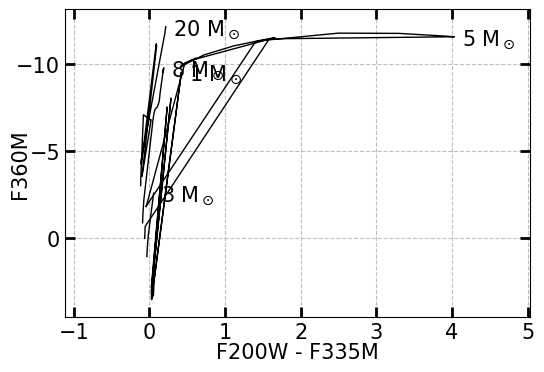

In [5]:
MakeCMD(instrument='nircam', xmodel=['F200W', 'F335M'], ymodel='F360M')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

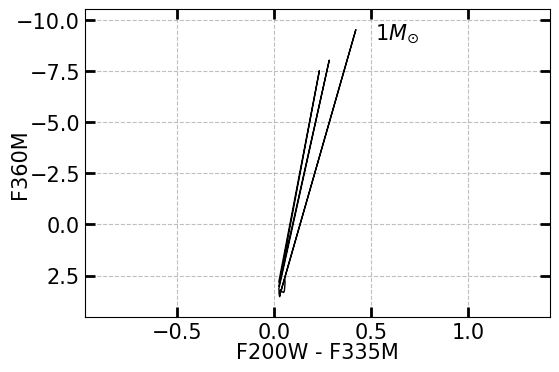

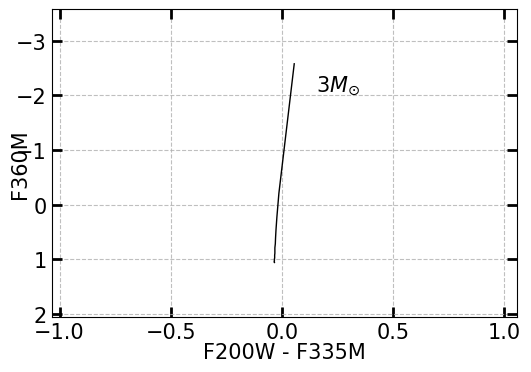

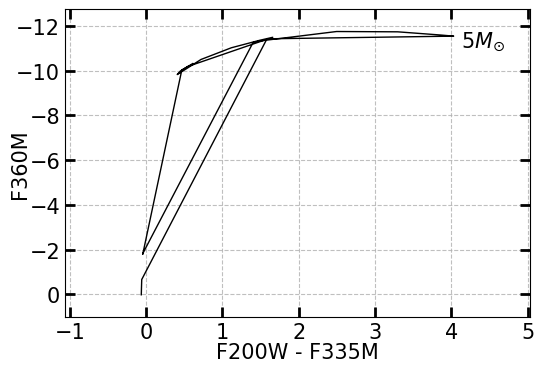

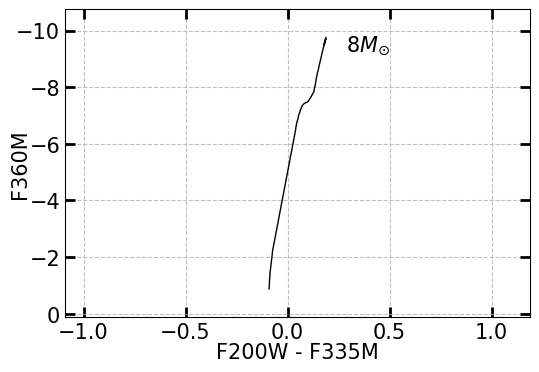

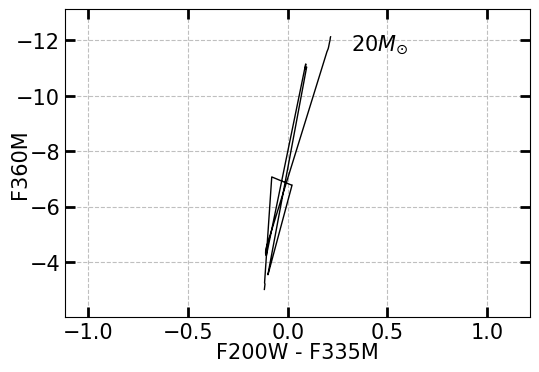

In [9]:
plot_cmd(masses=[solarmass1], mass_labels=[r'$1M_{\odot}$', r'$2M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')
plot_cmd(masses=[solarmass3], mass_labels=[r'$3M_{\odot}$', r'$2M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')
plot_cmd(masses=[solarmass5], mass_labels=[r'$5M_{\odot}$', r'$2M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')
plot_cmd(masses=[solarmass8], mass_labels=[r'$8M_{\odot}$', r'$2M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')
plot_cmd(masses=[solarmass20], mass_labels=[r'$20M_{\odot}$', r'$2M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')

### $5M_{\odot}$

- Check to see if the points in the figure are sorted by increasing age. If not, reorder them so that you don't have the line zig-zagging through different ages.
- Break the plot up by segments to see which parts of the model are plotted where. Remove the parts that don't look good and stitch the remaining parts together to make a solid, flowing line.
- Try a colormap to track the ages of each part of the line. Likely, some of those lines that zig-zag across the figure are from either very early or very late ages. This will help you determine where to make cuts.
- It looks as though there aren't many points in these figures. You may want to try to query the CMD website with a smaller step-size to get more data points, but only after you have good way to make a smooth line with the points you currently have.

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

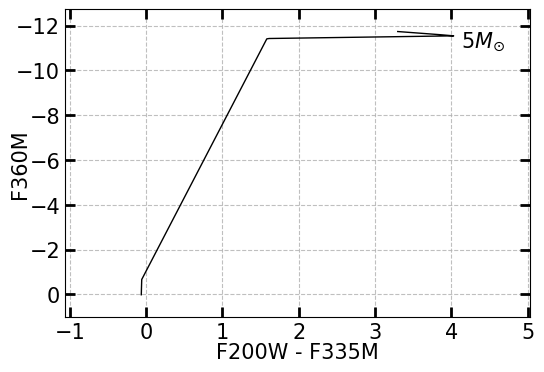

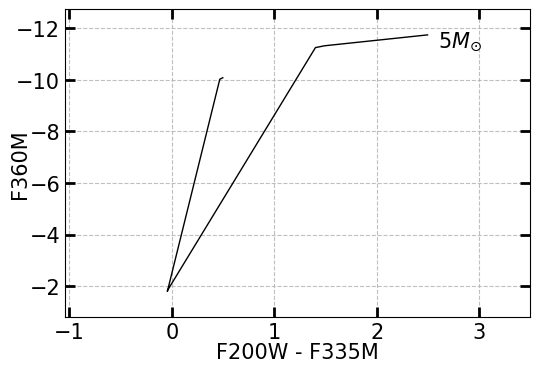

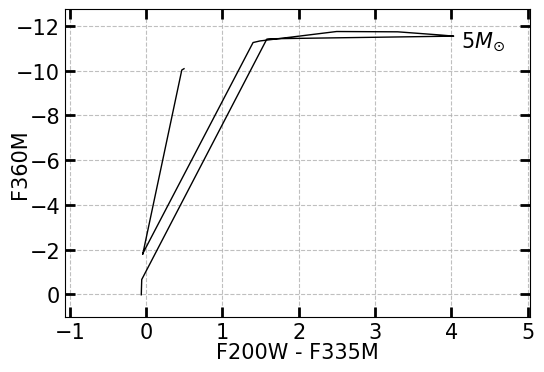

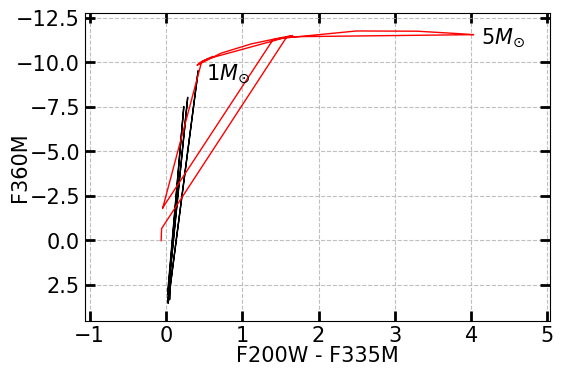

In [112]:
segment1 = solarmass5[:10]
segment2 = solarmass5[10:20]
segment3 = solarmass5[20:]
plot_cmd(masses=[segment1], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')
plot_cmd(masses=[segment2], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')
plot_cmd(masses=[solarmass5[:20]], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')
plot_cmd(masses=[solarmass1, solarmass5], mass_labels=[r'$1M_{\odot}$', '$5M_{\odot}$'], xmodel=['F200W', 'F335M'], ymodel='F360M')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

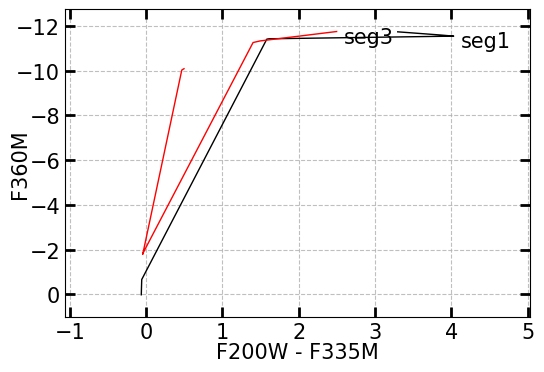

In [118]:
plot_cmd(masses=[segment1, segment2], mass_labels=[r'seg1','seg3'],
         xmodel=['F200W', 'F335M'], ymodel='F360M',
         save=False, savefile='test-segments-5solarmass.jgp')


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

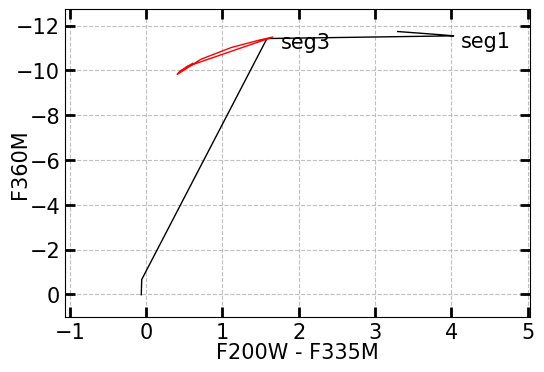

In [132]:
segment1 = solarmass5[:10]
segment2_1 = solarmass5[10:15]
segment2_2= solarmass5[15:20]
plot_cmd(masses=[segment1, segment3], mass_labels=[r'seg1','seg3'],
         xmodel=['F200W', 'F335M'], ymodel='F360M', 
         save=True, savefile='test-seg1-seg3.jpg')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

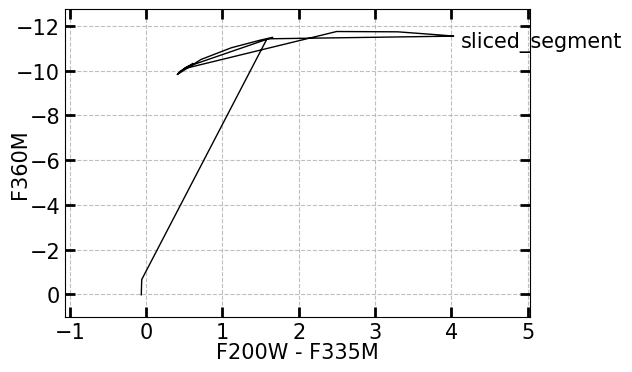

In [143]:
sliced_segment = solarmass5.drop([i for i in range(11, 19)], inplace=False)
plot_cmd(masses=[sliced_segment], mass_labels=['sliced_segment'],
        xmodel=['F200W', 'F335M'], ymodel='F360M')

### New isochrone dataset with step size 0.02

In [145]:
headers = "Zini     MH   logAge Mini        int_IMF         Mass   logL    logTe  logg  label   McoreTP C_O  period0  period1  period2  period3  period4  pmode  Mloss  tau1m   X   Y   Xc  Xn  Xo  Cexcess  Z 	 mbolmag  F070W  F090W F115W  F150W  F200W  F277W  F356W F444W  F150W2  F322W2  F140M F162M  F182M  F210M F250M  F300M  F335M  F360M  F410M  F430M F460M  F480M"
names=[i for i in headers.split(" ") if i != "" and i != "\t"]
isodata = pd.read_csv("isochrone-query-step-0_02.txt", delim_whitespace=True, comment="#", names=names)
isodata["ID"] = [i for i in range(len(isodata))]
isodata

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,6.60000,0.090000,1.081690,0.090,-1.674,3.4146,3.676,0,...,6.044,5.998,5.873,5.579,5.381,5.236,5.283,5.334,5.315,0
1,0.0152,0.01508,6.60000,0.090446,1.085948,0.090,-1.672,3.4147,3.677,0,...,6.040,5.994,5.869,5.575,5.377,5.232,5.279,5.330,5.311,1
2,0.0152,0.01508,6.60000,0.104545,1.207988,0.105,-1.617,3.4202,3.707,0,...,5.908,5.864,5.740,5.449,5.254,5.110,5.155,5.207,5.189,2
3,0.0152,0.01508,6.60000,0.112700,1.269209,0.113,-1.583,3.4236,3.719,0,...,5.830,5.786,5.663,5.377,5.184,5.042,5.086,5.137,5.119,3
4,0.0152,0.01508,6.60000,0.120294,1.321247,0.120,-1.566,3.4252,3.737,0,...,5.792,5.748,5.626,5.342,5.151,5.009,5.052,5.104,5.086,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70686,0.0152,0.01508,10.12005,0.961370,2.464454,0.667,3.251,3.4941,-0.060,7,...,-6.626,-6.339,-6.609,-6.787,-6.846,-6.773,-6.658,-6.578,-6.635,70686
70687,0.0152,0.01508,10.12005,0.961370,2.464454,0.661,3.297,3.4873,-0.137,7,...,-6.774,-6.467,-6.732,-6.941,-7.011,-6.939,-6.820,-6.745,-6.803,70687
70688,0.0152,0.01508,10.12005,0.961370,2.464454,0.651,3.339,3.4813,-0.210,7,...,-6.909,-6.582,-6.842,-7.083,-7.165,-7.096,-6.973,-6.904,-6.961,70688
70689,0.0152,0.01508,10.12005,0.961371,2.464454,0.636,3.367,3.4782,-0.261,7,...,-6.994,-6.658,-6.916,-7.174,-7.263,-7.197,-7.073,-7.007,-7.064,70689


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,6.60,5.000000,2.614067,4.999,2.743,4.2440,4.322,1,...,0.015,0.036,0.056,0.067,0.072,0.080,0.084,0.089,0.093,140
1,0.0152,0.01508,6.62,5.000000,2.614067,4.999,2.744,4.2438,4.321,1,...,0.012,0.033,0.054,0.064,0.070,0.078,0.082,0.086,0.090,523
2,0.0152,0.01508,6.64,5.000000,2.614067,4.999,2.744,4.2436,4.319,1,...,0.010,0.031,0.051,0.062,0.067,0.075,0.079,0.084,0.088,895
3,0.0152,0.01508,6.66,5.000000,2.614067,4.999,2.744,4.2434,4.318,1,...,0.007,0.028,0.049,0.059,0.065,0.073,0.077,0.081,0.085,1282
4,0.0152,0.01508,6.68,5.000000,2.614067,4.999,2.745,4.2432,4.317,1,...,0.004,0.025,0.046,0.056,0.062,0.070,0.074,0.078,0.082,1648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.0152,0.01508,8.06,5.021017,2.614175,5.010,4.050,3.5488,0.235,7,...,-8.286,-8.077,-8.358,-8.418,-8.436,-8.390,-8.313,-8.167,-8.216,24912
118,0.0152,0.01508,8.06,5.021286,2.614176,5.007,4.093,3.5429,0.168,7,...,-8.432,-8.220,-8.505,-8.570,-8.590,-8.540,-8.459,-8.322,-8.373,24913
119,0.0152,0.01508,8.06,5.021506,2.614177,5.004,4.134,3.5376,0.105,7,...,-8.571,-8.355,-8.644,-8.715,-8.736,-8.684,-8.601,-8.472,-8.523,24914
120,0.0152,0.01508,8.06,5.021707,2.614178,4.998,4.175,3.5323,0.043,7,...,-8.708,-8.489,-8.783,-8.860,-8.882,-8.829,-8.744,-8.623,-8.675,24915


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

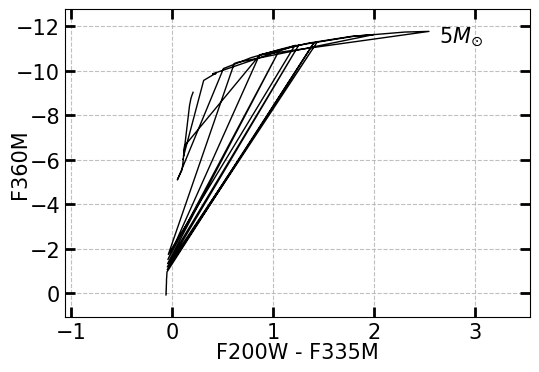

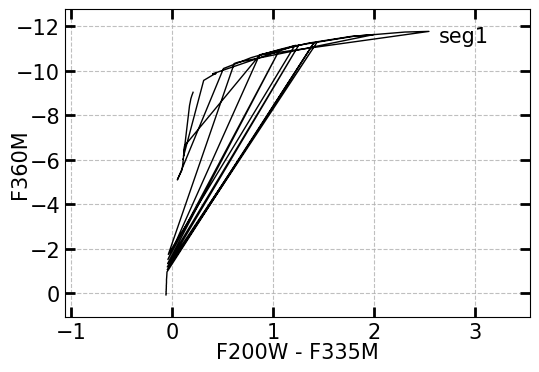

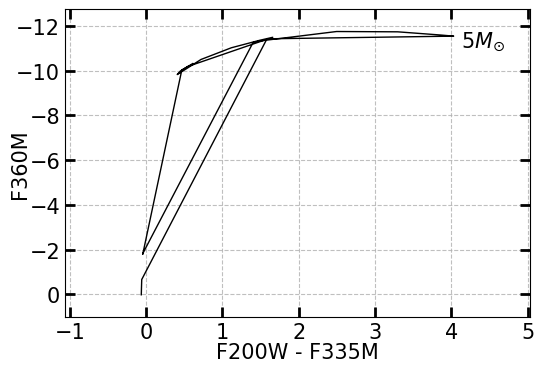

In [178]:
solar5 = Find(isodata, 'Mass >= 4.99')
solar5 = Find(solar5, 'Mass <= 5.01')
display(solar5)
plot_cmd(masses=[solar5], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'],
        ymodel='F360M')
plot_cmd(masses=[solar5[:]], mass_labels=[r'seg1'], xmodel=['F200W', 'F335M'],
        ymodel='F360M')
plot_cmd(masses=[solarmass5], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'],
        ymodel='F360M')

In [179]:
headers = "Zini     MH   logAge Mini        int_IMF         Mass   logL    logTe  logg  label   McoreTP C_O  period0  period1  period2  period3  period4  pmode  Mloss  tau1m   X   Y   Xc  Xn  Xo  Cexcess  Z 	 mbolmag  F070W  F090W F115W  F150W  F200W  F277W  F356W F444W  F150W2  F322W2  F140M F162M  F182M  F210M F250M  F300M  F335M  F360M  F410M  F430M F460M  F480M"
names=[i for i in headers.split(" ") if i != "" and i != "\t"]
isodata = pd.read_csv("isochrone-query-step-0_009.dat", delim_whitespace=True, comment="#", names=names)
isodata["ID"] = [i for i in range(len(isodata))]
isodata

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,6.60000,0.090000,1.081690,0.090,-1.674,3.4146,3.676,0,...,6.044,5.998,5.873,5.579,5.381,5.236,5.283,5.334,5.315,0
1,0.0152,0.01508,6.60000,0.090446,1.085948,0.090,-1.672,3.4147,3.677,0,...,6.040,5.994,5.869,5.575,5.377,5.232,5.279,5.330,5.311,1
2,0.0152,0.01508,6.60000,0.104545,1.207988,0.105,-1.617,3.4202,3.707,0,...,5.908,5.864,5.740,5.449,5.254,5.110,5.155,5.207,5.189,2
3,0.0152,0.01508,6.60000,0.112700,1.269209,0.113,-1.583,3.4236,3.719,0,...,5.830,5.786,5.663,5.377,5.184,5.042,5.086,5.137,5.119,3
4,0.0152,0.01508,6.60000,0.120294,1.321247,0.120,-1.566,3.4252,3.737,0,...,5.792,5.748,5.626,5.342,5.151,5.009,5.052,5.104,5.086,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157895,0.0152,0.01508,10.12793,0.956423,2.463313,0.658,3.238,3.4959,-0.046,7,...,-6.585,-6.304,-6.575,-6.745,-6.801,-6.729,-6.616,-6.535,-6.591,157895
157896,0.0152,0.01508,10.12793,0.956423,2.463313,0.652,3.286,3.4890,-0.126,7,...,-6.741,-6.439,-6.707,-6.907,-6.973,-6.901,-6.784,-6.707,-6.765,157896
157897,0.0152,0.01508,10.12793,0.956423,2.463313,0.642,3.330,3.4829,-0.201,7,...,-6.879,-6.558,-6.821,-7.053,-7.132,-7.063,-6.941,-6.871,-6.928,157897
157898,0.0152,0.01508,10.12793,0.956424,2.463314,0.627,3.359,3.4799,-0.253,7,...,-6.969,-6.639,-6.902,-7.150,-7.234,-7.167,-7.045,-6.978,-7.035,157898


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,6.60000,5.000000,2.614067,4.999,2.743,4.2440,4.322,1,...,0.015,0.036,0.056,0.067,0.072,0.080,0.084,0.089,0.093,140
1,0.0152,0.01508,6.60900,5.000000,2.614067,4.999,2.743,4.2440,4.321,1,...,0.014,0.035,0.055,0.066,0.071,0.079,0.083,0.088,0.092,524
2,0.0152,0.01508,6.61800,5.000000,2.614067,4.999,2.744,4.2439,4.321,1,...,0.013,0.033,0.054,0.065,0.070,0.078,0.082,0.087,0.090,923
3,0.0152,0.01508,6.62700,5.000000,2.614067,4.999,2.744,4.2438,4.320,1,...,0.011,0.032,0.053,0.064,0.069,0.077,0.081,0.085,0.089,1321
4,0.0152,0.01508,6.63600,5.000000,2.614067,4.999,2.744,4.2437,4.320,1,...,0.010,0.031,0.052,0.062,0.068,0.076,0.080,0.084,0.088,1712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.0152,0.01508,8.05797,4.998585,2.614059,4.997,3.205,3.6622,1.533,6,...,-5.429,-5.316,-5.481,-5.495,-5.501,-5.506,-5.474,-5.284,-5.314,54955
260,0.0152,0.01508,8.05797,5.000000,2.614067,4.999,3.201,3.6602,1.529,6,...,-5.430,-5.316,-5.482,-5.497,-5.503,-5.507,-5.475,-5.280,-5.312,54956
261,0.0152,0.01508,8.05797,5.005353,2.614094,5.004,3.188,3.6533,1.514,6,...,-5.441,-5.322,-5.495,-5.511,-5.517,-5.522,-5.490,-5.286,-5.319,54957
262,0.0152,0.01508,8.05797,5.031238,2.614227,5.008,4.176,3.5324,0.043,7,...,-8.712,-8.493,-8.786,-8.863,-8.886,-8.832,-8.748,-8.626,-8.679,54986


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

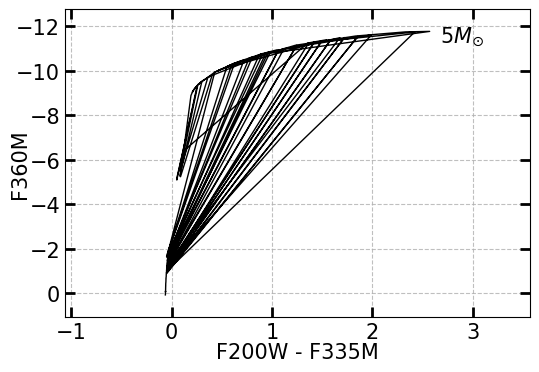

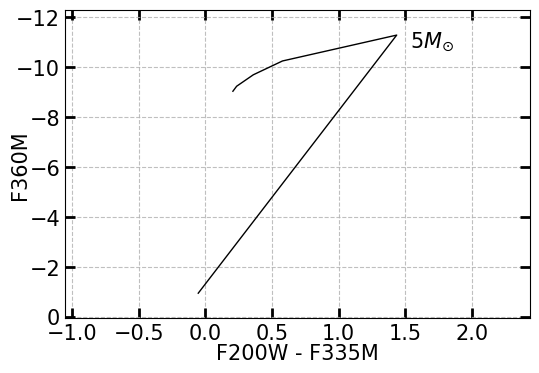

In [185]:
solar5 = Find(isodata, 'Mass >= 4.99')
solar5 = Find(solar5, 'Mass <= 5.01')
display(solar5)
plot_cmd(masses=[solar5], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'],
        ymodel='F360M')
plot_cmd([Find(solar5, 'Mass == 5')], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'],
        ymodel='F360M')

### $1M_{\odot}$

In [190]:
solar1

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,6.60000,0.090000,1.081690,0.090,-1.674,3.4146,3.676,0,...,6.044,5.998,5.873,5.579,5.381,5.236,5.283,5.334,5.315,0
1,0.0152,0.01508,6.60000,0.090446,1.085948,0.090,-1.672,3.4147,3.677,0,...,6.040,5.994,5.869,5.575,5.377,5.232,5.279,5.330,5.311,1
2,0.0152,0.01508,6.60000,0.104545,1.207988,0.105,-1.617,3.4202,3.707,0,...,5.908,5.864,5.740,5.449,5.254,5.110,5.155,5.207,5.189,2
3,0.0152,0.01508,6.60000,0.112700,1.269209,0.113,-1.583,3.4236,3.719,0,...,5.830,5.786,5.663,5.377,5.184,5.042,5.086,5.137,5.119,3
4,0.0152,0.01508,6.60000,0.120294,1.321247,0.120,-1.566,3.4252,3.737,0,...,5.792,5.748,5.626,5.342,5.151,5.009,5.052,5.104,5.086,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28303,0.0152,0.01508,10.12793,0.956423,2.463313,0.658,3.238,3.4959,-0.046,7,...,-6.585,-6.304,-6.575,-6.745,-6.801,-6.729,-6.616,-6.535,-6.591,157895
28304,0.0152,0.01508,10.12793,0.956423,2.463313,0.652,3.286,3.4890,-0.126,7,...,-6.741,-6.439,-6.707,-6.907,-6.973,-6.901,-6.784,-6.707,-6.765,157896
28305,0.0152,0.01508,10.12793,0.956423,2.463313,0.642,3.330,3.4829,-0.201,7,...,-6.879,-6.558,-6.821,-7.053,-7.132,-7.063,-6.941,-6.871,-6.928,157897
28306,0.0152,0.01508,10.12793,0.956424,2.463314,0.627,3.359,3.4799,-0.253,7,...,-6.969,-6.639,-6.902,-7.150,-7.234,-7.167,-7.045,-6.978,-7.035,157898


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,6.60000,0.090000,1.081690,0.090,-1.674,3.4146,3.676,0,...,6.044,5.998,5.873,5.579,5.381,5.236,5.283,5.334,5.315,0
1,0.0152,0.01508,6.60000,0.090446,1.085948,0.090,-1.672,3.4147,3.677,0,...,6.040,5.994,5.869,5.575,5.377,5.232,5.279,5.330,5.311,1
2,0.0152,0.01508,6.60000,0.104545,1.207988,0.105,-1.617,3.4202,3.707,0,...,5.908,5.864,5.740,5.449,5.254,5.110,5.155,5.207,5.189,2
3,0.0152,0.01508,6.60000,0.112700,1.269209,0.113,-1.583,3.4236,3.719,0,...,5.830,5.786,5.663,5.377,5.184,5.042,5.086,5.137,5.119,3
4,0.0152,0.01508,6.60000,0.120294,1.321247,0.120,-1.566,3.4252,3.737,0,...,5.792,5.748,5.626,5.342,5.151,5.009,5.052,5.104,5.086,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22970,0.0152,0.01508,10.12793,0.956423,2.463313,0.658,3.238,3.4959,-0.046,7,...,-6.585,-6.304,-6.575,-6.745,-6.801,-6.729,-6.616,-6.535,-6.591,157895
22971,0.0152,0.01508,10.12793,0.956423,2.463313,0.652,3.286,3.4890,-0.126,7,...,-6.741,-6.439,-6.707,-6.907,-6.973,-6.901,-6.784,-6.707,-6.765,157896
22972,0.0152,0.01508,10.12793,0.956423,2.463313,0.642,3.330,3.4829,-0.201,7,...,-6.879,-6.558,-6.821,-7.053,-7.132,-7.063,-6.941,-6.871,-6.928,157897
22973,0.0152,0.01508,10.12793,0.956424,2.463314,0.627,3.359,3.4799,-0.253,7,...,-6.969,-6.639,-6.902,-7.150,-7.234,-7.167,-7.045,-6.978,-7.035,157898


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

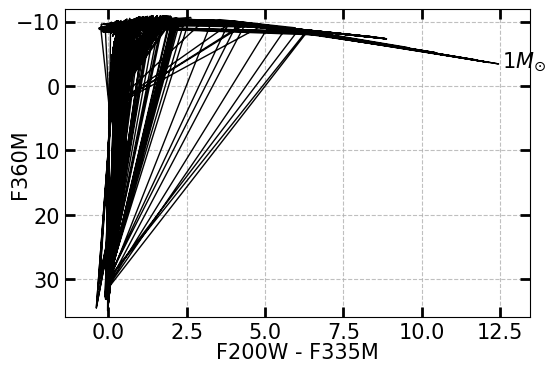

In [ ]:
solar1 = Find(isodata, 'Mass >= 0.999')
solar1 = Find(isodata, 'Mass <= 1.001')
display(solar1)
plot_cmd([solar1], mass_labels=[r'$1M_{\odot}$'], xmodel=['F200W', 'F335M'],
        ymodel='F360M')

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F210M,F250M,F300M,F335M,F360M,F410M,F430M,F460M,F480M,ID
0,0.0152,0.01508,6.60000,0.090000,1.081690,0.090,-1.674,3.4146,3.676,0,...,6.044,5.998,5.873,5.579,5.381,5.236,5.283,5.334,5.315,0
1,0.0152,0.01508,6.60000,0.090446,1.085948,0.090,-1.672,3.4147,3.677,0,...,6.040,5.994,5.869,5.575,5.377,5.232,5.279,5.330,5.311,1
2,0.0152,0.01508,6.60000,0.104545,1.207988,0.105,-1.617,3.4202,3.707,0,...,5.908,5.864,5.740,5.449,5.254,5.110,5.155,5.207,5.189,2
3,0.0152,0.01508,6.60000,0.112700,1.269209,0.113,-1.583,3.4236,3.719,0,...,5.830,5.786,5.663,5.377,5.184,5.042,5.086,5.137,5.119,3
4,0.0152,0.01508,6.60000,0.120294,1.321247,0.120,-1.566,3.4252,3.737,0,...,5.792,5.748,5.626,5.342,5.151,5.009,5.052,5.104,5.086,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124782,0.0152,0.01508,10.12793,0.956423,2.463313,0.658,3.238,3.4959,-0.046,7,...,-6.585,-6.304,-6.575,-6.745,-6.801,-6.729,-6.616,-6.535,-6.591,157895
124783,0.0152,0.01508,10.12793,0.956423,2.463313,0.652,3.286,3.4890,-0.126,7,...,-6.741,-6.439,-6.707,-6.907,-6.973,-6.901,-6.784,-6.707,-6.765,157896
124784,0.0152,0.01508,10.12793,0.956423,2.463313,0.642,3.330,3.4829,-0.201,7,...,-6.879,-6.558,-6.821,-7.053,-7.132,-7.063,-6.941,-6.871,-6.928,157897
124785,0.0152,0.01508,10.12793,0.956424,2.463314,0.627,3.359,3.4799,-0.253,7,...,-6.969,-6.639,-6.902,-7.150,-7.234,-7.167,-7.045,-6.978,-7.035,157898


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F200W - F335M', ylabel='F360M'>)

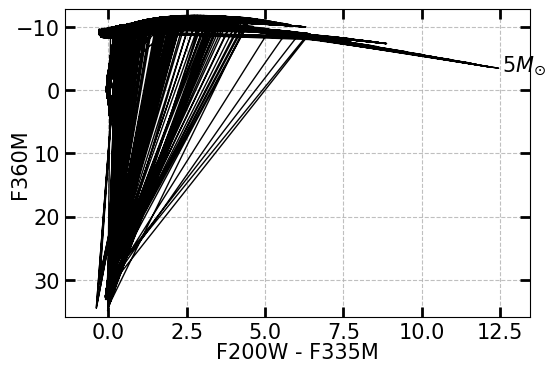

In [196]:
solar5 = Find(isodata, 'Mass >= 4.99')
solar5 = Find(isodata, 'Mass <= 5.01')
display(solar5)
plot_cmd([solar5], mass_labels=[r'$5M_{\odot}$'], xmodel=['F200W', 'F335M'],
        ymodel='F360M')